<center><h2>ALTeGraD 2024<br>Transfer learning for NLP</h2>

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        """
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         """
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid)  # nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(
            nhid, nhead, dim_feedforward=nhid, dropout=dropout
        )  # We assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, mask=src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output


class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout=dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100  # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value


model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape)

# The shape here is (batch_size, len(sequence), ntokens)
# Indeed, if we only considered the classification task, we would have only (batch_size, ntokens)
# But as we consider the language modeling task, we want for each token the probability of the next token

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


In [5]:
from prettytable import PrettyTable


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


count_parameters(model)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                     base.encoder.weight                     |   20000    |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |   120000   |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |    600     |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |   40000    |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |    200     |
|       base.transformer_encoder.layers.0.linear1.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear1.bias       |    200     |
|       base.transformer_encoder.layers.0.linear2.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear2.bias       |    200     |
|        base.transformer_encoder.layers.0.norm1.weight       |    200     |

1008100

## Vocabulary and Tokenization

In [6]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2024-10-21 14:11:53--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt.2’

dict.txt.2          100%[===================>] 564.05K  --.-KB/s    in 0.05s   

2024-10-21 14:11:53 (11.7 MB/s) - ‘dict.txt.2’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [7]:
path_vocab = "dict.txt"
token2ind = {
    "<sos>": 0,
    "<pad>": 1,
    "<eos>": 2,
    "<oov>": 3,
}  # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4

ind2token = {ind: token for token, ind in token2ind.items()}

print(ind2token[1111])

▁trop


### Data Loader


In [8]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] + [
            (
                self.token2ind[token]
                if token in self.token2ind
                else self.token2ind["<oov>"]
            )
            for token in sequence[: self.max_len]
        ]

        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        # we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch],
        padding_value=token2ind["<pad>"],
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=max_len,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [10]:
ntokens = len(ind2token)  # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2  # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [11]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind["<pad>"])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader):  # step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask)  # step 2
        if task == "classification":
            # last vector only
            output = output[-1]
        output = output.view(-1, output.shape[-1])
        target = data[1]
        target = target.to(device)

        loss = criterion(output, target)
        # step 3
        loss.backward()

        torch.nn.utils.clip_grad_norm_(
            model.parameters(), 0.5
        )  # prevent exploding gradient
        # step 4
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch,
                    idx,
                    len(data_loader),
                    cur_loss,
                    math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [12]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2024-10-21 14:12:15--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.3’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2024-10-21 14:12:15 (101 MB/s) - ‘pretraining_subset.txt.3’ saved [10146460/10146460]



In [13]:
# pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1):  # 5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.31804 | ppl 1507.245
| epoch   1 |  1000/ 3125 steps | loss 6.49649 | ppl  662.811
| epoch   1 |  1500/ 3125 steps | loss 6.20549 | ppl  495.461
| epoch   1 |  2000/ 3125 steps | loss 6.04590 | ppl  422.379
| epoch   1 |  2500/ 3125 steps | loss 5.92251 | ppl  373.349
| epoch   1 |  3000/ 3125 steps | loss 5.84074 | ppl  344.035
| epoch   2 |   500/ 3125 steps | loss 5.50158 | ppl  245.079
| epoch   2 |  1000/ 3125 steps | loss 5.49181 | ppl  242.696
| epoch   2 |  1500/ 3125 steps | loss 5.44327 | ppl  231.197
| epoch   2 |  2000/ 3125 steps | loss 5.40605 | ppl  222.751
| epoch   2 |  2500/ 3125 steps | loss 5.38973 | ppl  219.145
| epoch   2 |  3000/ 3125 steps | loss 5.35713 | ppl  212.115


## Text Generation


In [42]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2024-10-21 14:27:38--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   251MB/s    in 0.3s    

2024-10-21 14:27:38 (251 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-42-76a40ce8b80e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

<All keys matched successfully>

In [43]:
# !pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2024-10-21 14:27:44--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.1’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-10-21 14:27:44 (18.1 MB/s) - ‘sentencepiece.french.model.1’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [58]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind["<sos>"]] + [
        token2ind[el] for el in sent_pieces
    ]  # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1], axis=1)
    next_token_ind = next_token_ind.item()
    return next_token_ind, out


def infer_next_tokens(sent, max_len=50):
    if len(sent.split()) > max_len:
        raise ValueError("Sentence too long")

    for i in range(max_len - len(sent.split())):
        next_token_ind, out = infer_next_token(sent)

        if next_token_ind == token2ind["<eos>"]:
            break

        next_token = ind2token[next_token_ind]
        sent = sent + " " + s.decode_pieces([next_token])

    return sent

In [59]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques .'

### Supervised task

In [60]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2024-10-21 14:32:22--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm’

train.review.spm    100%[===================>]   1.43M  --.-KB/s    in 0.07s   

2024-10-21 14:32:22 (21.5 MB/s) - ‘train.review.spm’ saved [1495960/1495960]

--2024-10-21 14:32:22--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

In [66]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    model.eval()
    total_acc, total_length = 0, 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input = data[0].to(device)

            src_mask = model.base.generate_square_subsequent_mask(input.size(0)).to(
                device
            )
            output = model(input, src_mask)
            output = output[-1]

            target = data[1].to(device)

            total_length += len(target)
            total_acc += (torch.argmax(output, dim=1) == target).sum().item()

    total_acc = total_acc / total_length
    return total_acc

In [67]:
# save the base model to be loaded later in the fine-tuning phase
torch.save(
    {
        "model_state_dict": model.base.state_dict(),
    },
    "pretrained_model_4layers_no_class_head.pt",
)

In [68]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        # load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        # load state dict
        model.base.load_state_dict(checkpoint["model_state_dict"])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task="classification",
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task="classification",
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.76768 | ppl    2.155
| epoch   1 |   100/  200 steps | loss 0.72838 | ppl    2.072
| epoch   1 |   150/  200 steps | loss 0.70951 | ppl    2.033
| epoch   2 |    50/  200 steps | loss 0.64948 | ppl    1.915
| epoch   2 |   100/  200 steps | loss 0.62927 | ppl    1.876
| epoch   2 |   150/  200 steps | loss 0.55868 | ppl    1.748
| epoch   3 |    50/  200 steps | loss 0.45549 | ppl    1.577
| epoch   3 |   100/  200 steps | loss 0.42905 | ppl    1.536
| epoch   3 |   150/  200 steps | loss 0.42981 | ppl    1.537
| epoch   4 |    50/  200 steps | loss 0.18519 | ppl    1.203
| epoch   4 |   100/  200 steps | loss 0.20065 | ppl    1.222
| epoch   4 |   150/  200 steps | loss 0.14038 | ppl    1.151
| epoch   5 |    50/  200 steps | loss 0.06868 | ppl    1.071
| epoch   5 |   100/  200 steps | loss 0.03952 | ppl    1.040
| epoch   5 |   150/  200 steps | loss 0.04795 | ppl    1.049
| epoch   6 |    50/  200 steps | loss

<ipython-input-68-f09076582a3e>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")


| epoch   1 |    50/  200 steps | loss 0.08126 | ppl    1.085
| epoch   1 |   100/  200 steps | loss 0.08170 | ppl    1.085
| epoch   1 |   150/  200 steps | loss 0.00359 | ppl    1.004
| epoch   2 |    50/  200 steps | loss 0.00003 | ppl    1.000
| epoch   2 |   100/  200 steps | loss 0.00359 | ppl    1.004
| epoch   2 |   150/  200 steps | loss 0.03000 | ppl    1.030
| epoch   3 |    50/  200 steps | loss 0.00002 | ppl    1.000
| epoch   3 |   100/  200 steps | loss 0.00180 | ppl    1.002
| epoch   3 |   150/  200 steps | loss 0.02008 | ppl    1.020
| epoch   4 |    50/  200 steps | loss 0.00040 | ppl    1.000
| epoch   4 |   100/  200 steps | loss 0.00000 | ppl    1.000
| epoch   4 |   150/  200 steps | loss 0.00001 | ppl    1.000
| epoch   5 |    50/  200 steps | loss 0.04469 | ppl    1.046
| epoch   5 |   100/  200 steps | loss 0.00042 | ppl    1.000
| epoch   5 |   150/  200 steps | loss 0.00555 | ppl    1.006
| epoch   6 |    50/  200 steps | loss 0.07535 | ppl    1.078
| epoch 

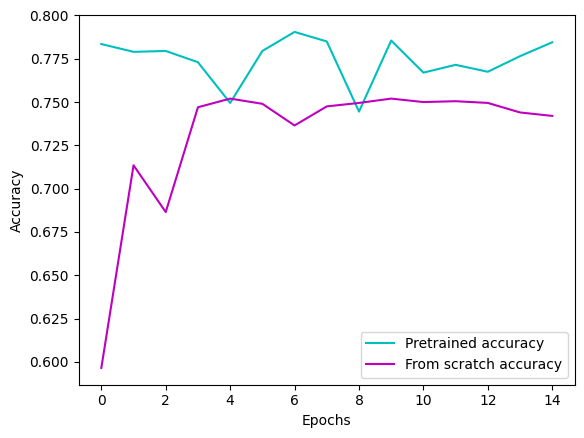

In [69]:
# Visualize the accuracy
import matplotlib.pyplot as plt

plt.plot(pretrained_valid_acc, "c", label="Pretrained accuracy")
plt.plot(from_scratch_valid_acc, "m", label="From scratch accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()